296826### Lab 6 - EE350
# Filtres RII

À rendre le 14 decembre 2021

MEMBRES DU GROUPE : HAMMOUMI Abir 302910
TITOVA Xenia 296826

In [1]:
# Requirements
! pip install scipy
! pip install numpy
! pip install matplotlib

In [2]:
# Imports
from scipy import signal, special
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt
import math

## Exercice 1: Filtre RII passe-bas

On peut voir sur la figure 1 le gabarit d'un filtre numérique passe-bas. On aimerait construire un tel filtre par conversion d'un filtre analogique grâce à la transformée bilinéaire.

![picture](characteristics.png)

On aimerait que ce filtre respecte les spécifications suivantes:
* Oscillation en bande passante (ou oscillation crête-à-crête, reliée au paramètre $\delta_1$): $\leq -1$ dB. Le gabarit est donc donné par $1 - \delta_1 = -1 $ dB.
* Fréquence maximale de la bande passante: $\omega_p = 0.4 \pi$.
* Niveau maximum en bande coupée (relié au paramètre $\delta_2$) : $ \leq -22$ dB.
* Fréquence minimale de la bande coupée: $\omega_s = 0.7 \pi$.
* Fréquence d'échantillonnage: $F_e = 3$ kHz.

**Conseils:**

* Pour déterminer l'ordre d'un filtre analogique, on a besoin des paramètres suivants $\delta, \epsilon, \Omega_p$ et $\Omega_s$. Puisque la conversion analogique-numérique se fait avec la transformation bilinéaire, vous devrez utiliser la transformation non-linéaire des fréquences pour transformer les spécifications données pour le filtre numérique $\omega_p$ et $\omega_s$ en fréquences analogiques $\Omega_p$ et $\Omega_s$.
* Pour rappel, les relations reliant $\delta$ et $\epsilon$ à $\delta_1$, $\delta_2$ sont:
$$
\begin{align}
\delta_2 = \frac{1}{\sqrt{1 + \delta^2}} \\
\frac{1}{\sqrt{1 + \epsilon^2}} = 1 - \delta_1.
\end{align}
$$
* Pour rappel, l'expression en décibels d'une valeur $\delta$ normalisée peut être trouvée comme suit:
$$
    \delta_{dB} = 20 \log_{10}(\delta).
$$

* Attention: pour ne pas faire d'erreur dans le signe des différentes grandeurs, il est utile de se représenter l'axe des ordonnées en décibels : 1 devient 0, $1- \delta_1$ devient une valeur négative (-1db), et $\delta_2$ est une valeur négative bien plus basse (-22db). Notez que $1-\delta_1$ et $\delta_2$ sont nécessairement plus petits que 1 et que leur valeur en db sera donc toujours négative. Cependant, certaines fonctions prennent en argument la valeur absolue des décibels (positive, donc). Lisez bien la documentation de chaque fonction.


**1. Calculer les paramètres $\delta, \epsilon, \Omega_p$ et $\Omega_s$ nécessaires pour le design des filtres analogiques.**

**Réponse :**
* $\epsilon$: On sait que $\frac{1}{\sqrt{1 + \epsilon^2}} = 1 - \delta_1$, on peut déduire:
    \begin{equation*}
        20 \log_{10} \Big( \frac{1}{\sqrt{1 + \epsilon^2}} \Big) = -1 \quad \implies \quad \epsilon = 0.5088.
    \end{equation*}
* $\delta$: En se rappelant que $\delta_2  = \frac{1}{\sqrt{1 + \delta^2}}$, on peut déduire:
    \begin{equation*}
        20 \log_{10} \Big(\frac{1}{\sqrt{1 + \delta^2}} \Big) = -22 \quad \implies \quad \delta = 12,5494.
    \end{equation*}
* $\Omega_p$: On utilise la transformation bilinéaire pour trouver $\Omega_p$ à partir de $\omega_p$:
    \begin{equation*}
        \Omega_p = \frac{2}{T} \tan(\omega_p/2) = \frac{2}{T} \tan(\pi/5),
    \end{equation*}
    avec $T$ la période d'échantillonage.
* $\Omega_s$: on utilise la même procédure que pour $\Omega_p$:
    \begin{equation*}
        \Omega_s = \frac{2}{T} \tan(7 \pi/20) ,
    \end{equation*}
    


**2. Déterminez analytiquement l'ordre du filtre numérique Butterworth qui respecte le gabarit donné. Vérifiez le résultat avec la fonction `scipy.signal.buttord`.**

**Réponse :** 
Pour le filtre de Butterworth, l'ordre minimal du filtre est:
    
$N_{\min} \geq \dfrac{\log(\delta / \epsilon)}{\log(\frac{\Omega_s}{\Omega_p}) } = 3,2256 \implies N= 4$
    
Ceci peut être vérifié grâce au code ci-dessous.

In [3]:
# Code
wp = 0.4
ws = 0.7
rp = 1
rs = 22

N_butter, w_butter = signal.buttord(wp=wp, ws=ws, gpass=1, gstop=22)

print(N_butter)
print(w_butter)

4
0.4522564538480536


**3. Si on utilise un filtre de Chebyshev, quel type de filtre (type I ou type II) est le plus adapté à ces spécifications ? Justifiez.**

**Réponse :**
On peut voir dans les spécifications du filtre que le principal facteur limitant est son oscillation en bande passante qui doit être très faible ($0.4$ dB), cela indique que l'application nécessitant un tel filtre doit être probablement sensible aux oscillations en bande passante, que l'on va minimiser en choisissant un filtre de type II.

**4. Déterminez analytiquement l'ordre du filtre numérique Chebyshev (du type déterminé à la question précédente) qui respecte le gabarit donné. Vérifiez les résultats avec les fonctions `scipy.signal.cheb1ord` ou `scipy.signal.cheb2ord`.**

**Réponse :**
Pour le filtre de Chebyshev de type II, l'ordre minimal du filtre est:
    
$N_{\min} \geq \dfrac{\cosh^{-1} (\delta / \epsilon)}{\cosh^{-1} (\frac{\Omega_s}{\Omega_p})}= 2.3612 \quad \implies \quad N=3.$

avec $\frac{\delta}{\epsilon} = 24.6647$ et $\frac{\Omega_s}{\Omega_p} = 2,7013$

In [4]:
# Code
wp = 0.4
ws = 0.7
rp = 1
rs = 22

N_cheby2 = np.arccosh(12.549/0.509)/np.arccosh(11775.7/4359.3)
print("Calcul analytique:" +str(N_cheby2))

N_cheb, w_cheb = signal.cheb2ord(wp=wp, ws=ws, gpass=1, gstop=22)

print("N =", N_cheb)
print("Wn =", w_cheb)

Calcul analytique:2.361224324748109
N = 3
Wn = 0.6117368536232997


**5. Déterminez analytiquement l'ordre du filtre numérique elliptique qui respecte le gabarit donné. (Vous pouvez calculer les intégrales elliptiques en utilisant la fonction `scipy.special.ellipk`). Vérifiez le résultat avec la commande `scipy.signal.ellipord`.**

**Réponse :** 
Pour le filtre elliptique, l'ordre minimal du filtre est:
    
$$
\begin{align}
N_{\min} & \geq \dfrac{K \big(\frac{\Omega_p}{\Omega_s}\big)}
{K\big(\sqrt{1-(\frac{\Omega_p}{\Omega_s})^2}\big)} \cdot \dfrac{K\big(\sqrt{1-(\frac{\epsilon}{\delta})^2}\big)}{K \big(\frac{\epsilon}{\delta }\big)} \\
&= \dfrac{K\big(0.3701\big)}{K\big(0.0405\big)} \cdot \dfrac{K\big(0.9992\big)}{K \big(0.9289\big)}
\end{align}
$$

In [5]:
# Code
#Calcul analytique
x1 = 0.39 # ~ Omega_p/Omega_s
x2 = 0.99 # ~ sqrt(1-epsilon^2/delta^2)
x3 = 0.041 # ~ epsilon/delta
x4 = 0.93 # ~ sqrt(1-Omega_p^2/Omega_s^2)
K1 = special.ellipk(x1)
K2 = special.ellipk(x2)
K3 = special.ellipk(x3)
K4 = special.ellipk(x4)
N_ellip = (K1*K2)/(K3*K4)
print("Calcul analytique: " + str(N_ellip))

print("Vérification : ")

wp = 0.4
ws = 0.7
rp = 1
rs = 22

N_e, w_ellip = signal.ellipord(wp,ws,rp,rs)

print("N =", N_e)
print("Wn =", w_ellip)

Calcul analytique: 1.5007138235447195
Vérification : 
N = 2
Wn = 0.4


**6. Tracez la réponse en amplitude et en phase pour chacun des filtres ci-dessus, ainsi que le gabarit imposé (vous pouvez utiliser les fonctions `scipy.signal.butter`, `scipy.signal.cheby1` or `scipy.signal.cheby2`, `scipy.signal.ellip` pour créer les filtres et `scipy.signal.freqz` pour observer le comportement fréquentiel). Discutez les résultats et comparez la performance des filtres.**

**Attention :** dans le cours, nous avons vu que pour construire des filtres numériques RII, on transforme les spécifications dans le domaine analogique afin de choisir le bon filtre analogique. Ensuite, on convertit ce filtre en filtre numérique par la transformation bilinéaire. 
Cependant, les fonctions `butter, cheby` et `ellip` font cette conversion automatiquement: on peut donner directement en argument les spécifications du filtre numérique, sans avoir à faire les conversions.


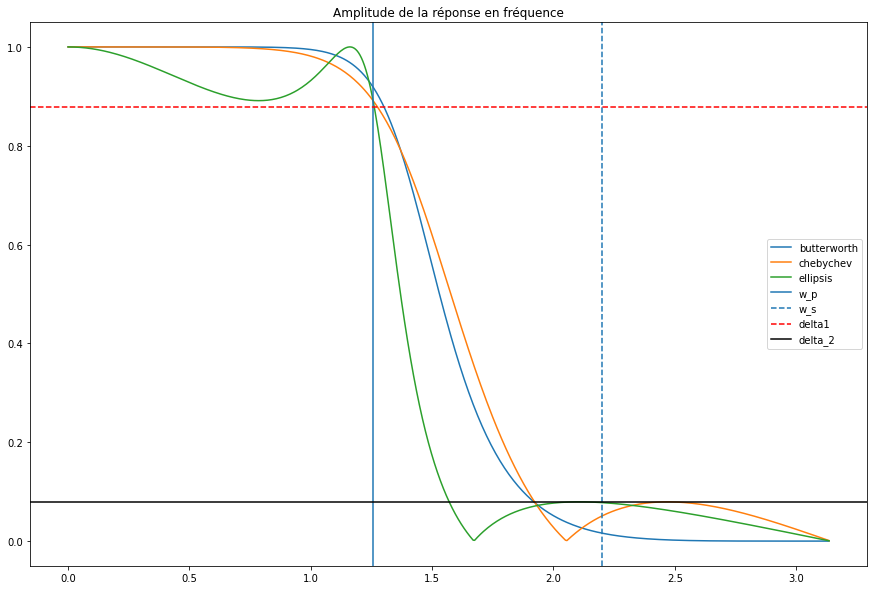

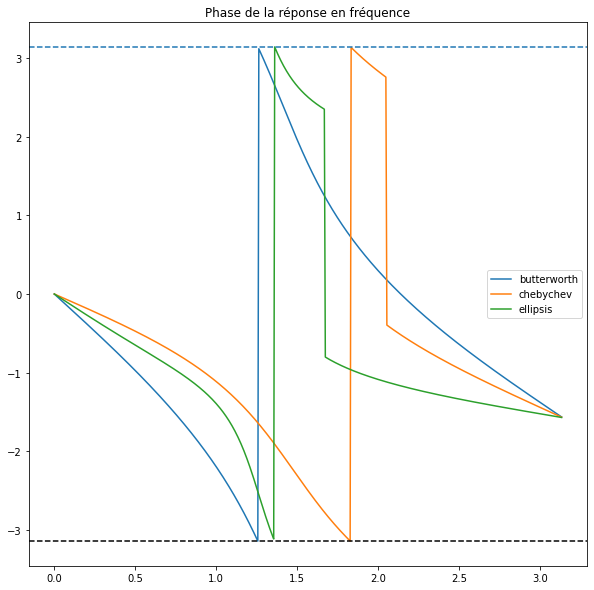

In [6]:
# Code
b_butter, a_butter = signal.butter(5, w_butter)
b_cheby, a_cheby = signal.cheby2(3, rs, w_cheb)
b_ellip, a_ellip = signal.ellip(3, rp, rs, w_ellip)

w_butter1, h_butter1 = signal.freqz(b_butter, a_butter)
w_cheb1, h_cheb1 = signal.freqz(b_cheby, a_cheby)
w_ellip1, h_ellip1 = signal.freqz(b_ellip, a_ellip)

plt.figure(figsize=(15, 10))
plt.plot(w_butter1, np.abs(h_butter1), label='butterworth')
plt.plot(w_cheb1, np.abs(h_cheb1), label='chebychev')
plt.plot(w_ellip1, np.abs(h_ellip1), label='ellipsis')
plt.axvline(x=0.4 *math.pi , ymin = 0, label='w_p')
plt.axvline(x=0.7 * math.pi, ymin = 0, linestyle = '--', label='w_s')
plt.axhline(y=2 - 10 ** (1 / 20), xmin=0, xmax=math.pi, linestyle='--', label='delta1', color='r')
plt.axhline(y=10 ** (-22/20), xmin=0, xmax=math.pi, label='delta_2', color='k')
plt.legend()
plt.title("Amplitude de la réponse en fréquence")


plt.figure(figsize=(10, 10))
plt.plot(w_butter1, np.angle(h_butter1), label='butterworth')
plt.plot(w_cheb1, np.angle(h_cheb1), label='chebychev')
plt.plot(w_ellip1, np.angle(h_ellip1), label='ellipsis')
plt.axhline(y=math.pi, xmin=0, xmax=math.pi,linestyle = '--')
plt.axhline(y=- math.pi, xmin=0, xmax=math.pi, linestyle = '--', color='k')
plt.legend()
plt.title("Phase de la réponse en fréquence")
plt.show()

**Réponse :** 
On peut remarquer que les trois filtres sont en accord avec les spécifications données. En terme d'oscillations, le filtre elliptique est le seul a en avoir en bande passante. On peut remarquer que le filtre de Butterworth possède une transition (entre bande passante et bande coupée) et une réponse en phase sans changement brusque, contrairement aux deux autres filtres qui possèdent des sauts dans leurs réponses. 

**7. Tracez le diagramme pôles-zéros pour chacun des filtres ci-dessus. Discutez du placement des pôles et des zéros, les diagrammes sont-ils cohérents avec le fait que les filtres sont passe-bas? (Vous pouvez utiliser la fonction `scipy.signal.tf2zpk` pour tracer le diagramme).**

<Figure size 432x288 with 0 Axes>

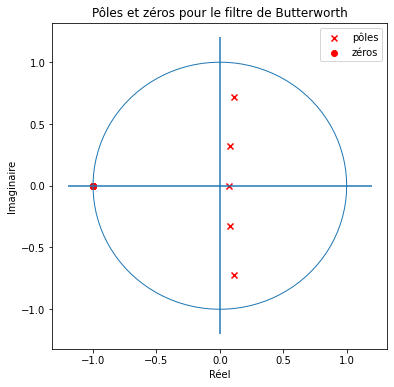

<Figure size 432x288 with 0 Axes>

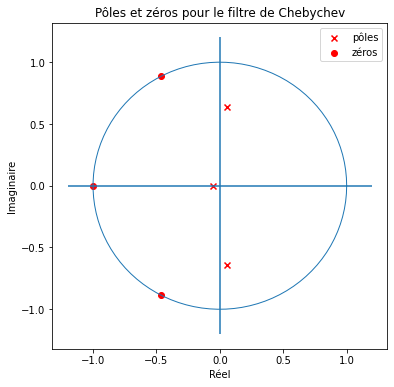

<Figure size 432x288 with 0 Axes>

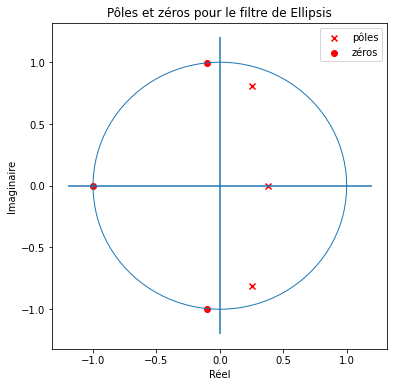

In [7]:
# Code
z_butter, p_butter, _ = signal.tf2zpk(b_butter, a_butter)
z_cheb, p_cheb, _ = signal.tf2zpk(b_cheby, a_cheby)
z_ellip, p_ellip, _ = signal.tf2zpk(b_ellip, a_ellip)

# Code from lab 4:
def plot_poles_zeros(p, z, titre):
    t = np.linspace(0, 2*np.pi, 100)
    plt.figure()
    fig = plt.figure(figsize=(6,6))
    
    plt.plot(np.cos(t), np.sin(t), linewidth=1)
    plt.vlines(0, ymin=-1.2, ymax=1.2)
    plt.hlines(0, xmin=-1.2, xmax=1.2)
    plt.scatter(p.real, p.imag, marker='x', c='r', label='pôles')
    plt.scatter(z.real, z.imag, marker='o', c='r', label='zéros')
    plt.legend()
    plt.title(f"Pôles et zéros pour le filtre de {titre}")
    plt.xlabel("Réel")
    plt.ylabel("Imaginaire")
    
plot_poles_zeros(p_butter, z_butter, "Butterworth")
plot_poles_zeros(p_cheb, z_cheb, "Chebychev")
plot_poles_zeros(p_ellip, z_ellip, "Ellipsis")

**Réponse :** 
L'ordre de chaque filtre est bien donné par le nombre de pôles. Les 3 filtres sont stables (tous les pôles sont situés à l'intérieur du cercel unité). Oui, les diagrammes sont cohérents avec les fait que les filtres sont passe-bas car tous les zéros ont une partie inférieure à zéro.

# Exercice 2 : Conversion de filtres

## Exercise 2.1: Filtres passe-bas
Les filtres RII sont généralement basés sur des équivalents analogiques (Butterworth, Chebyshev, etc.), qui sont convertis en utilisant la transformation bilinéaire qui transfère les pôles et les zéros du filtre analogique dans le domaine numérique (plans des $z$). 

La transformation bilinéaire est une transformation du domaine des $s$ au domaine des $z$ qui préserve les caractéristiques de fréquence et est définie par:

\begin{equation}
    s=\frac{2}{T} \frac{1-z^{-1}}{1+z^{-1}}
\end{equation}

Considérez le filtre passe-bas suivant :
\begin{equation} H_a(s)=\frac{\Omega_p}{s+\Omega_p}
\end{equation}
    
avec la fréquence de coupure *$\Omega_p=1$ rad/s*. Concevez un filtre passe-bas RII $H_1(z)$ de fréquence de coupure $\omega_p=\pi/20$ rad/échantillon à partir de $H_a(s)$ en utilisant la méthode de la transformation bilinéaire.

**Méthode :**
  - Écrivez $H_1(z)$  sous une forme analytique en fonction de $T$ et déterminez la valeur de $T$ telle que la fréquence de coupure du filtre $H_1(z)$ soit $\omega_p$.
  - Tracez l'amplitude de la réponse fréquentielle $|H_1(w)|$ et le diagramme pôles-zéros du filtre. Interprétez les caractéristiques fréquentielles du filtre en fonction de la localisation de ses pôles et ses zéros.

**Réponse :**
On a :
    \begin{equation*}
        H_1(z)=\frac{\Omega_p(1+z^{-1})}{\frac{2}{T} +\Omega_p -z^{-1}(\frac{2}{T} - \Omega_p)}
    \end{equation*}
    D'après les questions précédentes, on avait déterminé que 
    \begin{equation*}
        \Omega_p = \frac{2}{T} \tan \frac{\omega_p}{2} => T = \frac{2}{\Omega_p} \tan \frac{\omega_p}{2}
    \end{equation*}
    
Or $\Omega_p = 1$ rad/s (qui correspond au pôle de $H_1(s)$), $\omega_p= \pi/20$. 
    Cela donne $T=0.1574$. 
    

T =  0.15740341364923688


<Figure size 432x432 with 0 Axes>

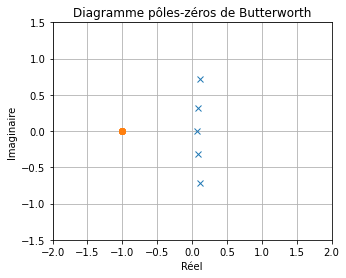

<Figure size 432x432 with 0 Axes>

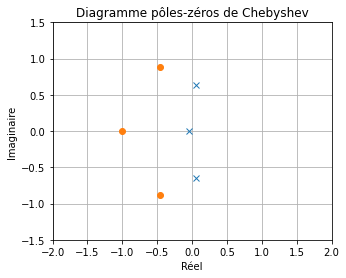

<Figure size 432x432 with 0 Axes>

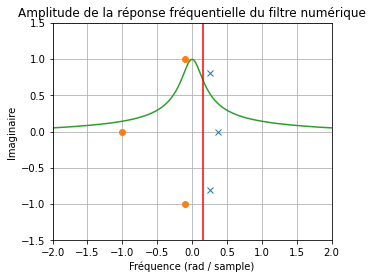

<Figure size 432x288 with 0 Axes>

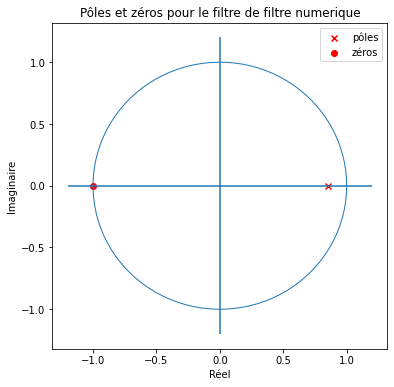

In [11]:
# Code
def PoleZeroPlot(b, a, filtre):
    z, p, k = signal.tf2zpk(b, a)
    #fig = plt.figure(figsize=(6,6))
    plt.figure()
    plt.plot(p.real, p.imag, 'x', z.real, z.imag, 'o')
    plt.title("Diagramme pôles-zéros de " +str(filtre))
    plt.grid()
    
    plt.xlim((-2, 2))
    plt.xlabel('Réel')
    plt.ylim((-1.5, 1.5))
    plt.ylabel('Imaginaire')
    plt.gcf().set_figwidth(5)
    return 
PoleZeroPlot(b_butter, a_butter, "Butterworth")
PoleZeroPlot(b_cheby, a_cheby, "Chebyshev")#PoleZeroPlot(b_cheby2, a_cheby2, "Chebyshev")
PoleZeroPlot(b_ellip, a_ellip, "elliptique")#PoleZeroPlot(b_ell, a_ell, "elliptique")

T = 2 / 1 * np.tan(math.pi / 40)
print("T = ", T)

omega = np.linspace(-math.pi, math.pi, 200)
z = np.exp(1j * omega )

H1 =  (1 + 1/z) / (2 / T + 1 - 1/z * (2 / T - 1))

plt.plot(omega, np.abs(H1))
plt.axvline(math.pi / 20, color='red')
plt.title("Amplitude de la réponse fréquentielle du filtre numérique")
plt.xlabel("Fréquence (rad / sample)")
plt.show()

b = [1, 1]
a = [2 / T + 1, - 2 / T + 1]
z, p, _ = signal.tf2zpk(b, a)
plot_poles_zeros(p, z, "filtre numerique")

**Analyse :** On voit que c'est un filtre passe-bas : l'amplitude de laréponse fréquentielle possède un pic en 0 et les autres fréquences sont atténuées. C'est aussi ce qu'on remarque pour le graphe des pôles et zéros du filtre numérique : il y a le pôle est dans les basses fréquences.

## Exercice 2.2 : Filtres passe-bande


**1.**  En utilisant la relation de transformation bilinéaire, écrivez la forme générale du filtre passe-bande $ H_2(z) $  à partir du filtre passe-bas analogique de l'exercice 2.1 en utilisant la transformation:
$$
\begin{equation}
        s\rightarrow \Omega_p \frac{s^2 + \Omega_l \Omega_u}{s(\Omega_u - \Omega_l)}
 \end{equation}
$$
Vous pouvez poser $ \lambda_1 = \Omega_u - \Omega_l$ et $ \lambda_2 = \Omega_u\Omega_l$.

**Réponse** :
$H(z) = \frac{2T\lambda_1(1-z^{-2})}{z^{-2}(4-2T\lambda_1+T^2\lambda_2) + z^{-1}(2T^2\lambda_2 -8) + (4+2T\lambda_1 +T^2\lambda_2)}$


## Exercice 2.3 : Application de la conversion de filtre


Nous allons maintenant créer une série de filtres passe-bande et les appliquer a un signal. 

La fonction freq_arr() renvoie une liste, X, de fréquences (numériques) de coupure inférieure et supérieure choisies en fonction de la perception des différentes fréquences par l'oreille humaine (également appelée échelle de Mel). La relation est la suivante: $\omega_l $ = X[i] et $\omega_u $ = X[i +1] et $ i = 1, 2, .... N_{filt} $. Grâce à cela, vous pouvez concevoir des filtres passe-bande $ N_{filt} $ de différentes bandes passantes.


In [ ]:
def freq_arr(fs):
    """ Ne pas modifier cette cellule -- do not change this cell
    Cette fonction génère les pulsations de coupure basses et haut pour l'ensemble des filtres
    Fréquence de sortie : en Hertz.(Numérique)"""
    nfilt = 10
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    return hz_points

Complétez le squelette de code avec les étapes suivantes :
    
**1.** Chargez musique.wav. Vous pouvez utiliser wavfile.read.

**2.** Tracez l'amplitude de la réponse en fréquence du fichier musique.wav.

**3.** À partir de freq_arr( ), obtenez la liste des fréquences de coupure $\omega_l, \omega_u$ en utilisant la fréquence d'échantillonnage de musique.wav

**4.** Complétez la fonction convert_discrete_to_continuous() qui doit convertir les valeurs en fréquences analogiques $\Omega_l, \Omega_u$  (en rads/sample) en utilisant la relation des fréquences: 
$$
\begin{equation}
\Omega = \frac{2}{T}tan(\frac{\omega}{2}) 
\end{equation}
$$

**5.** Complétez la fonction construct_digital_bandpass_filter( ), qui utilise les valeurs de $\Omega_l, \Omega_u$ pour construire des filtres passe-bande numériques, en utilisant la relation obtenue à la Question 2.2.1.

**6.** Complétez le squelette de code qui itère à travers les fréquences générées par freq_arr (). Dans cette boucle :
 - Utilisez la fonction convert_discrete_to_continuous( ) pour générer des fréquences continues.
 - Construisez des filtres passe-bande en les utilisant avec la fonction construct_digital_bandpass_filter( ).
 - Tracez l'amplitude de la réponse en fréquence de chaque filtre (utiliser `signal.freqz`).
 - Appliquez ces filtres au signal musique.wav (en utilisant `scipy.lfilter`) et visualisez l'amplitude du sprectre du signal filtré. Enregistrez les signaux filtrés dans un fichier .wav à l'aide de la fonction :
`wavfile.write('name.wav', int(fs), np.asarray(output, dtype=np.int16))`.



In [ ]:
# Template code for Ex2.3.1,  Ex2.3.2 and Ex2.3.3

wav_file = 'musique.wav'
# TODO (Ex2.3.1): Read the wav file using wavfile.read and put the output in wav_fs, wav_data respectively
wav_fs, wav_data = wavfile.read(wav_file)
fs = wav_fs
T = 1/fs

wav_N = np.linspace(-wav_fs/2.0, wav_fs/2.0, wav_data.shape[0])
wav_fft = np.fft.fft(wav_data)
wav_fft_freq = np.fft.fftshift(np.abs(wav_fft)/wav_data.shape[0])

# TODO (Ex2.3.2): Plot the magnitude of the frequency response of the audio file


plt.title('Transformée de Fourier de la musique')
plt.plot(wav_N, wav_fft_freq, 'b')
plt.grid('on')
plt.ylabel('|X (w))|')
plt.xlabel('Fréquences (Hz)')
plt.show()

# TODO (Ex2.3.3): Generate the freq lower and upper bounds for the band pass using the sampling frequency.
filters_arr = freq_arr(fs)




In [ ]:
# Template code for Ex2.3.4
# TODO:
# Convert from Discrete to Continuous Frequency using the bilinear transform relation
def convert_discrete_to_continuous(f_discrete_l, f_discrete_u, T):
    # Convert to rad/s from Hz
    omega_discrete_l = 2*np.pi*f_discrete_l*T
    omega_discrete_u = 2*np.pi*f_discrete_u*T

    # Convert from Discrete to Continuous Frequency using bilinear transform
    omega_cont_l = 2*np.tan(omega_discrete_l/2.0)/T
    omega_cont_u = 2*np.tan(omega_discrete_u/2.0)/T
    
    return omega_cont_l, omega_cont_u

In [ ]:
# Template code for Ex2.3.5
# TODO:
# Construct the digital band-pass filter defined in Ex2.2.1 
def construct_digital_bandpass_filter(omega_cont_l, omega_cont_u, T):
    lambda_1 = omega_cont_u - omega_cont_l
    lambda_2 = omega_cont_u*omega_cont_l

    a_coeffs = [(4+2*lambda_1*T+lambda_2*(T**2)), (2*(T**2)*lambda_2-8), (-2*T*lambda_1+4+(T**2)*lambda_2)]
    b_coeffs = [2*T*lambda_1, 0,-2*T*lambda_1]
    
    return a_coeffs, b_coeffs

In [ ]:
# Code Ex.2.3.6
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
ax[0].set_title('Réponse en fréquence du filtre')
ax[1].set_title('Réponse en fréquence de musique filtré')
legends = []

for i in range(0, len(filters_arr)-1):
    # Load the Digital frequency(Hz) as provided by the freq_arr() function
    f_discrete_l = filters_arr[i]
    f_discrete_u = filters_arr[i+1]
    
    # TODO: Ex2.3.6, 1st bullet: Convert from Discrete to Continuous Frequency using the bilinear transform relation
    omega_cont_l, omega_cont_u = convert_discrete_to_continuous(f_discrete_l, f_discrete_u, T)
    
    # TODO: Ex2.3.6 2nd bullet: Construct the digital band-pass filter defined in Ex2.2.1 
    a_coeffs, b_coeffs = construct_digital_bandpass_filter(omega_cont_l, omega_cont_u, T)
    w, h = signal.freqz(b_coeffs, a_coeffs) 
    
    # TODO: Ex2.3.6 3rd bulltet : Plot the magnitude of the frequency response of the digital band-pass filter
    ax[0].plot(0.5*fs*w/np.pi, abs(h))
    
    # Ex2.3.6 4th bulltet : Filter the .wav using lfilter
    y_band_wav = signal.lfilter(b_coeffs,a_coeffs, wav_data)
    wavfile.write('band_pass_'+str(i)+'.wav', int(wav_fs), np.asarray(y_band_wav, dtype=np.int16)) 
    
    # TODO: Ex2.3.6: Plot the magnitude of the frequency response of the filtered .wav
    aN = wav_data.shape[0]
    wav_ft = np.linspace(-wav_fs/2.0, wav_fs/2.0, wav_data.shape[0])
    ax[1].plot(wav_ft, fftshift(np.abs(fft(y_band_wav))/y_band_wav.shape[0]))
    legends.append('filter_num =%d' % (i+1))

ax[0].grid('on')
ax[0].set_ylabel('Amplitude du filtre')
ax[0].set_xlabel('Fréquence [Hz]')
ax[0].legend(legends)

ax[1].grid('on')
ax[1].set_ylabel('Amplitude du fichier musique')
ax[1].set_xlabel('Fréquence [Hz]')
ax[1].legend(legends)

plt.tight_layout()
plt.show()

**7.**  Regardez l'amplitude de chaque son filtré, écoutez ces sons et comparez-les aux signaux d'origine. Que peut-on dire sur notre perception des sons dans chaque bande de fréquence?

**Réponse :**

Quand la fréquence passante des filtres augmente, l'amplitude diminue. Quand on écoute, on perçoit mieux les basses fréquences que les hautes fréquences.